# Imports

In [ ]:
import numpy as np

#plots
from sklearn.manifold import TSNE
import cv2

import torch
import torchvision
import time
import torch
from torch import nn
import torch.nn.functional as F
#from torch.nn import Transformer

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
from google.colab import drive
# Connect to drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!curl https://raw.githubusercontent.com/carolinamcg/Vision-Transformer/master/train_eval.py > train_eval.py
!curl https://raw.githubusercontent.com/carolinamcg/Vision-Transformer/master/metrics.py > metrics.py
!curl https://raw.githubusercontent.com/carolinamcg/Vision-Transformer/master/model_ViT.py > model_ViT.py
!curl https://raw.githubusercontent.com/carolinamcg/Vision-Transformer/master/weight_init.py > weight_init.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11204  100 11204    0     0  47880      0 --:--:-- --:--:-- --:--:-- 47676
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1246  100  1246    0     0   5612      0 --:--:-- --:--:-- --:--:--  5612
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20918  100 20918    0     0  94225      0 --:--:-- --:--:-- --:--:-- 94225
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2625  100  2625    0     0  13530      0 --:--:-- --:--:-- --:--:-- 13461


In [ ]:
from train_eval import *
import metrics
from model_ViT import *
from weight_init import *

# Settings

In [ ]:
image_size = 28
patch_size = 7
in_channels=1
num_heads = 8
# normalization  parameters
mean = 0.1307
std = 0.3081
# path and directory
base_path='/content/drive/MyDrive/Anansi_00/ViT/' #path where you want to save your model's weights and results
model_name = "MNIST_myViT" #dir name to store your model's w and results
#model_name = "MNIST_myViT_NOPOSEMB"

# Load Data

In [ ]:
def one_hot(target):
    '''
    Converts a vector with all possible indexes/classes in one-hot encoded matrix
    (len(ids), num_classes)
    '''
    num_classes = 10
    #print(target)
    return np.squeeze(np.eye(num_classes)[target])

In [ ]:
# https://towardsdatascience.com/a-demonstration-of-using-vision-transformers-in-pytorch-mnist-handwritten-digit-recognition-407eafbc15b0
DOWNLOAD_PATH = '/data/mnist'
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 1000
# normalization  parameters
mean = 0.1307
std = 0.3081

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((mean,), (std,))])

train_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_mnist, target_transform=one_hot)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_mnist, target_transform=one_hot)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [ ]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: /data/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Target transform: <function one_hot at 0x7fe2f0404170>

In [ ]:
test_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: /data/mnist
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Target transform: <function one_hot at 0x7fe2f0404170>

In [ ]:
i = 0
for batch in train_loader:
  i += 1
  print(batch[1][:5], batch[1].shape)
  if i>=3:
    break

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64) torch.Size([64, 10])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=torch.float64) torch.Size([64, 10])
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64) torch.Size([64, 10])


# Functions

In [ ]:
def plot_history(history, n_epochs):
    for metric in ['Accuracy', 'Loss']:
      # summarize history for accuracy and loss
      legend = []
      for k in history.keys(): 
        if metric in k:
          plt.plot(history[k])
          legend.append(k)
      plt.title('model' + metric)
      plt.ylabel(metric)
      plt.xlabel('epoch')
      plt.legend(legend, loc='upper left')
      plt.show()

# Vision Transformer Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_Softargmax = nn.Softmax  # fix wrong name

In [ ]:
assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
num_patches = (image_size // patch_size) ** 2
patch_dim = in_channels * patch_size ** 2
print(num_patches, patch_dim)

16 49


## With learned pos embeddings

(add_pos_emb=True, standard1Dpe=False)

In [ ]:
model = ViT(num_layers=6, d_model=64, num_heads=num_heads, conv_hidden_dim=128, patch_size=patch_size, 
            num_answers=10, att_dropout_rate=0, dropout_rate=0,
            num_patches=num_patches, no_embed_classtoken=False, standard1Dpe=False, in_channels=in_channels, 
            cnn=False, class_token=True, add_pos_emb=True, pool='', classif_hidden=128,
            pre_logits=False, weight_init=False)
model.to(device)

ViT(
  (embedding): Embeddings(
    (patch_embeddings): Conv2d(1, 64, kernel_size=(7, 7), stride=(7, 7), padding=valid)
  )
  (pos_embed): PositionalEncoding()
  (pos_dropout): Dropout(p=0, inplace=False)
  (enc_layers): ModuleList(
    (0): EncoderLayer(
      (layernorm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=False)
        (W_k): Linear(in_features=64, out_features=64, bias=False)
        (att_dropout): Dropout(p=0, inplace=False)
        (proj_dropout): Dropout(p=0, inplace=False)
        (W_v): Linear(in_features=64, out_features=64, bias=False)
        (W_h): Linear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0, inplace=False)
      (layernorm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (cnn): CNN(
        (k1convL1): Linear(in_features=64, out_features=128, bias=True)
        (activation): GELU(approximate=none)
      

In [ ]:
epochs = 25
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
train_eval = Training(model, epochs, model_name, optimizer=optimizer, criterion=F.cross_entropy, base_path=base_path)
train_eval.print_parameters()

213,770 total parameters.
213,770 training parameters.



Epoch 0: train_loss=0.3868, train_acc=0.8701, val_loss=0.1416, val_acc=0.9548, 
Saving best model for epoch: 0, Best validation loss: 0.141604982316494

Epoch 1: train_loss=0.1313, train_acc=0.9594, val_loss=0.1209, val_acc=0.9617, 
Saving best model for epoch: 1, Best validation loss: 0.12090023085474969

Epoch 2: train_loss=0.1030, train_acc=0.9683, val_loss=0.1286, val_acc=0.9617, 
Epoch 3: train_loss=0.0860, train_acc=0.9728, val_loss=0.0904, val_acc=0.9719, 
Saving best model for epoch: 3, Best validation loss: 0.0903954602777958

Epoch 4: train_loss=0.0757, train_acc=0.9755, val_loss=0.0909, val_acc=0.9724, 
Epoch 5: train_loss=0.0683, train_acc=0.9777, val_loss=0.0753, val_acc=0.9776, 
Saving best model for epoch: 5, Best validation loss: 0.07528288140892983

Epoch 6: train_loss=0.0590, train_acc=0.9812, val_loss=0.0833, val_acc=0.9767, 
Epoch 7: train_loss=0.0538, train_acc=0.9830, val_loss=0.0740, val_acc=0.9772, 
Saving best model for epoch: 7, Best validation loss: 0.0739785

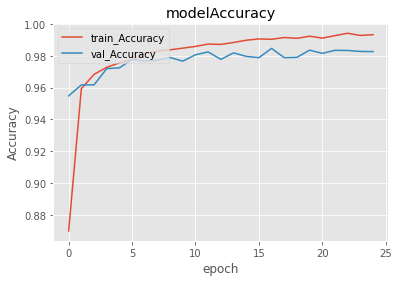

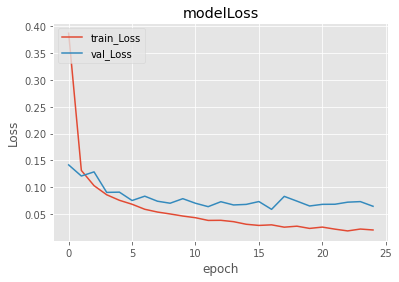

In [ ]:
train_eval.train(train_loader, test_loader, checkpoint_metric='val_Loss')
plot_history(train_eval.history, epochs)

## Without pos embeddings

(model_name ends in NOPOSEMB)

In [ ]:
model = ViT(num_layers=6, d_model=64, num_heads=num_heads, conv_hidden_dim=128, patch_size=patch_size, 
            num_answers=10, att_dropout_rate=0, dropout_rate=0,
            num_patches=num_patches, no_embed_classtoken=False, standard1Dpe=False, in_channels=in_channels, 
            cnn=False, class_token=True, add_pos_emb=False, pool='', classif_hidden=128,
            pre_logits=False, weight_init=False)
model.to(device)

ViT(
  (embedding): Embeddings(
    (patch_embeddings): Conv2d(1, 64, kernel_size=(7, 7), stride=(7, 7), padding=valid)
  )
  (pos_embed): Identity()
  (pos_dropout): Dropout(p=0, inplace=False)
  (enc_layers): ModuleList(
    (0): EncoderLayer(
      (layernorm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=False)
        (W_k): Linear(in_features=64, out_features=64, bias=False)
        (att_dropout): Dropout(p=0, inplace=False)
        (proj_dropout): Dropout(p=0, inplace=False)
        (W_v): Linear(in_features=64, out_features=64, bias=False)
        (W_h): Linear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0, inplace=False)
      (layernorm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (cnn): CNN(
        (k1convL1): Linear(in_features=64, out_features=128, bias=True)
        (activation): GELU(approximate=none)
        (dropout

In [ ]:
epochs = 25
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
train_eval = Training(model, epochs, model_name, optimizer=optimizer, criterion=F.cross_entropy, base_path=base_path)
train_eval.print_parameters()

212,682 total parameters.
212,682 training parameters.



Epoch 0: train_loss=0.6526, train_acc=0.7796, val_loss=0.3249, val_acc=0.8970, 
Saving best model for epoch: 0, Best validation loss: 0.3249197632074356

Epoch 1: train_loss=0.2838, train_acc=0.9103, val_loss=0.2692, val_acc=0.9143, 
Saving best model for epoch: 1, Best validation loss: 0.26918441653251646

Epoch 2: train_loss=0.2150, train_acc=0.9322, val_loss=0.2246, val_acc=0.9330, 
Saving best model for epoch: 2, Best validation loss: 0.22459215372800828

Epoch 3: train_loss=0.1745, train_acc=0.9440, val_loss=0.1722, val_acc=0.9469, 
Saving best model for epoch: 3, Best validation loss: 0.1721518814563751

Epoch 4: train_loss=0.1420, train_acc=0.9541, val_loss=0.1438, val_acc=0.9553, 
Saving best model for epoch: 4, Best validation loss: 0.14377794563770294

Epoch 5: train_loss=0.1218, train_acc=0.9604, val_loss=0.1436, val_acc=0.9543, 
Saving best model for epoch: 5, Best validation loss: 0.1435518592596054

Epoch 6: train_loss=0.1049, train_acc=0.9660, val_loss=0.1818, val_acc=0.

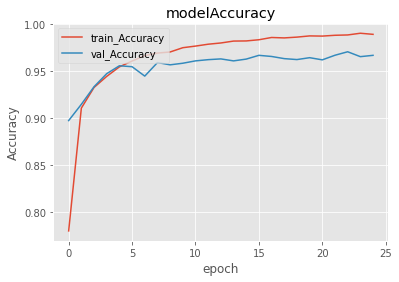

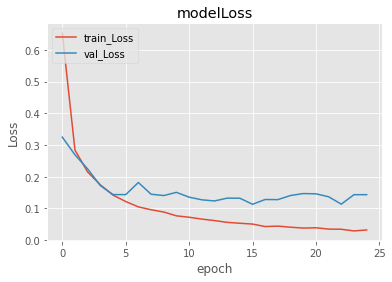

In [ ]:
train_eval.train(train_loader, test_loader, checkpoint_metric='val_Loss')
plot_history(train_eval.history, epochs)

# Investigating Vision Transformer representations

(https://keras.io/examples/vision/probing_vits/#method-i-mean-attention-distance)


Load best model weights:

In [ ]:
# load the best model checkpoint
best_model_cp = torch.load('{}weights/{}/best_model.pth'.format(base_path, model_name))
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

Best model was saved at 16 epochs



In [ ]:
print('Loading best epoch saved model weights...')
model.load_state_dict(best_model_cp['model_state_dict'])

Loading best epoch saved model weights...


<All keys matched successfully>

Choose random test images as examples and visualize them:

In [ ]:
def test(model, test_loader, n=None):
  np.random.seed(0)
  model.eval()
  with torch.no_grad():
    for batch in test_loader:
      x = batch[0].float().to(device)
      y = batch[1].float().to(device)

      out, A = model(x)
      preds = out.argmax(1).detach().cpu().numpy()
      targets = y.argmax(1).detach().cpu().numpy()
      #print(x.size(), A['layer_0'].size())

      if n is not None:
        #random selection of n//2 wrongly predicted images
        wrong_pred = np.where(preds!=targets)[0]
        p = np.random.permutation(wrong_pred.shape[0])
        wanted_ids = wrong_pred[p[:n//2]]
        gt_mislabeled = targets[wanted_ids]
        print("gt_mislabeled: ", gt_mislabeled)

        #for each wrong predicted class selected, select a correct prediction of that class
        correct_pred = np.where(preds==targets)[0]
        print("Rate of correct predictions: ", correct_pred.shape[0] / preds.shape[0])
        for gt in np.unique(gt_mislabeled):
          count = np.count_nonzero(gt_mislabeled==gt)
          #print(gt, count)
          gt_correct_ids = np.where(targets[correct_pred]==gt)[0][:count]
          wanted_cids = correct_pred[gt_correct_ids]
          wanted_ids = np.hstack((wanted_ids, wanted_cids))

        #wanted_ids = wanted_ids.reshape(-1)
        print("Wanted image ids: ", wanted_ids)
        image_tensors = x[wanted_ids, :, :, :].detach().cpu().numpy()
        preds = preds[wanted_ids]
        targets = targets[wanted_ids]
        attn_mat = A # for each key/layer: (num_images, num_heads, n_patches, n_patches)
        for k in A.keys():
          attn_mat[k] = A[k][wanted_ids, :, :, :].detach().cpu()
      else:
        attn_mat = A
        for k in A.keys():
          attn_mat[k] = A[k][:, :, :, :].detach().cpu()
        image_tensors = x.detach().cpu().numpy()
        wanted_ids = None
      break

  return image_tensors, targets, preds, attn_mat, wanted_ids

In [ ]:
test_loader_plots = torch.utils.data.DataLoader(test_set, batch_size=10000, shuffle=False)

In [ ]:
ex_imgs, ex_gt, pred_labels, attn_weights_dict, orig_img_ids = test(model, test_loader_plots, n=16)

gt_mislabeled:  [7 7 9 8 4 3 8 8]
Rate of correct predictions:  0.9846
Wanted image ids:  [1156 3976 9808 4807 1112  449 1878 4639   18    4    0   17   61   84
  110    7]


In [ ]:
print(ex_imgs.shape, ex_gt.shape, pred_labels.shape, attn_weights_dict['layer_0'].shape)
print(ex_gt, pred_labels)

(16, 1, 28, 28) (16,) (16,) torch.Size([16, 8, 17, 17])
[7 7 9 8 4 3 8 8 3 4 7 7 8 8 8 9] [8 3 4 0 6 5 3 9 3 4 7 7 8 8 8 9]


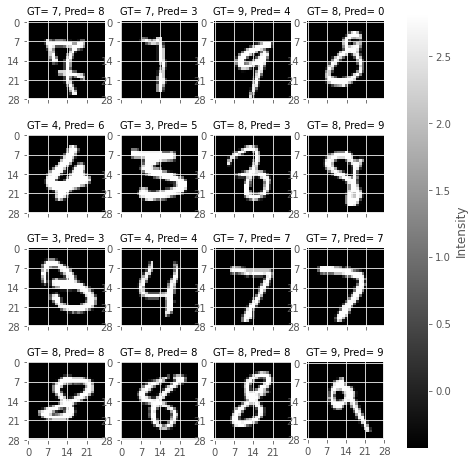

In [ ]:
def visualize_imgs(imgs, labels, preds):
  assert len(imgs) % 4 ==0, "Number of image examles should be multiple of 4"
  f, ax_arr = plt.subplots(int(len(imgs)/4), 4, sharex=True, squeeze=True, figsize=(8,8))
  n_ticks = np.sqrt(num_patches) + 1
  for id in range(len(imgs)):
    i = id//4
    j = id - (i*4)
    ax = ax_arr[i, j]
    im = ax.imshow(imgs[id, 0, :, :], cmap='gray', interpolation='nearest')
    ax.set_title(f"GT= {labels[id]}, Pred= {preds[id]}", size=10)
    ax.set_xticks(np.arange(n_ticks)*patch_size)
    ax.set_yticks(np.arange(n_ticks)*patch_size)

  im.cmap.set_under("w")
  cbar = f.colorbar(im, ax=ax_arr.ravel().tolist(), label='Intensity')
  #plt.tight_layout()
  plt.show()

visualize_imgs(ex_imgs, ex_gt, pred_labels)

## Attention Mean Head Distance


In [ ]:
def compute_distance_matrix(patch_size, num_patches, length):
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def compute_mean_attention_dist(patch_size, attention_weights):
    num_cls_tokens = 1 #+1 in the attention dimensions

    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ].numpy()  # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token.
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # Sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # Now average across all the tokens

    return mean_distances

def visualize_MAHD(attention_score_dict, patch_size, num_heads):
  print(f"Num Heads: {num_heads}.")
  legends = [f"head_{i}" for i in range(num_heads)]

  plt.figure(figsize=(9, 9))

  for k in attention_score_dict.keys():
    mean_distances = compute_mean_attention_dist(patch_size, attention_score_dict[k][:, :, :, :])
    idx = int(k.split("_")[-1]) #layer index
    x = [idx] * num_heads #each hyead distnace will be plotted in the same x coordinate
    y = mean_distances[0, :]
    plt.scatter(x=x, y=y, label=k)

    for i, txt in enumerate(legends):
      plt.annotate(txt, (x[i] + 0.1, y[i] + 0.1))

  plt.legend(loc="upper left")
  plt.xlabel("NN Depth (layer)", fontsize=14)
  plt.ylabel("Attention Distance", fontsize=14)
  plt.title("Mean Attention Distance", fontsize=14)
  plt.grid()
  plt.show()

In [ ]:
all_imgs, all_gt, all_pred_labels, attention_score_dict, _ = test(model, test_loader_plots, n=None)

In [ ]:
print(all_imgs.shape, all_gt.shape, all_pred_labels.shape, attention_score_dict['layer_0'].shape)
print(all_gt, all_pred_labels)

(10000, 1, 28, 28) (10000,) (10000,) torch.Size([10000, 8, 17, 17])
[7 2 1 ... 4 5 6] [7 2 1 ... 4 5 6]


Seeing the mean attention distance for the test set (first image in this example plot), it seems that this transformer is focusing more on local information (distance < 15), regardless of the depth/layer.

Num Heads: 8.


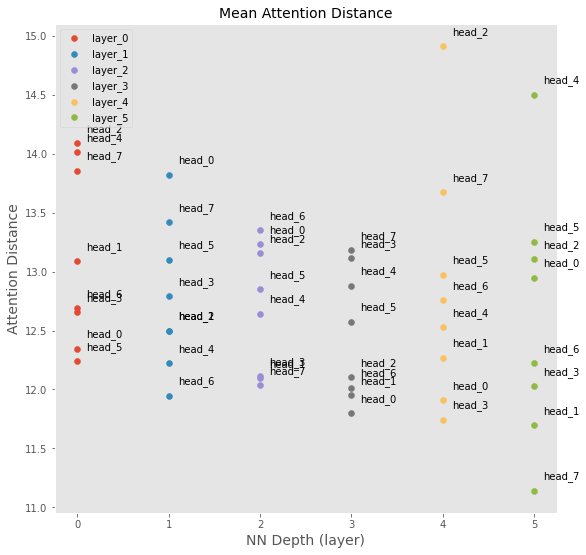

In [ ]:
visualize_MAHD(attention_score_dict, patch_size, num_heads)

## Attention Rollout

Abnar et al. introduce "Attention rollout" for quantifying how information flow through self-attention layers of Transformer blocks. Original ViT authors use this method to investigate the learned representations, stating:


> *Briefly, we averaged attention weights of ViTL/16 across all heads and then recursively multiplied the weight matrices of all layers. This accounts for the mixing of attention across tokens through all layers.*




In [ ]:
def attention_rollout_map(image, attention_score_dict, img_id):
  num_cls_tokens = 1 #+1 in the attention dimensions

  # Stack the individual attention matrices from individual Transformer blocks.
  attn_mat = torch.stack([attention_score_dict[k][img_id, :, :, :] for k in attention_score_dict.keys()]) #(num_layers, num_heads, num_patches+1, num_patches+1)
  #print(torch.stack([torch.from_numpy(np.array(int(k[-1]))) for k in attention_score_dict.keys()]))
  # order of the layers in the stack: layer_0, layer_1, ... (stacks vertically)
  attn_mat = torch.squeeze(attn_mat, axis=1)
  #print(attn_mat.size())

  # Average the attention weights across all heads.
  attn_mat = torch.mean(attn_mat, axis=1) #(num_layers, num_patches+1, num_patches+1)
  #print(attn_mat.size())

  # To account for residual connections, we add an identity matrix to the
  # attention matrix and re-normalize the weights.
  residual_attn = torch.eye(attn_mat.size(1))
  aug_attn_mat = attn_mat + residual_attn
  aug_attn_mat = aug_attn_mat / aug_attn_mat.sum(dim=-1).unsqueeze(-1)
  #print(aug_attn_mat.sum(dim=-1).unsqueeze(-1).size()) #(num_layers, num_patches+1, 1)
  #aug_attn_mat  = (num_layers, num_patches+1, num_patches+1)

  # Recursively multiply the weight matrices of each layer
  joint_attentions = torch.zeros(aug_attn_mat.size())
  joint_attentions[0] = aug_attn_mat[0]

  for n in range(1, aug_attn_mat.shape[0]):
    joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n -1]) #respecting the order of attention multiplication: H = An...A0V

  # Attention from the output token to the input space.
  v = joint_attentions[-1] # #product of all layers' weight matrices multiplication
  grid_size = int(np.sqrt(aug_attn_mat.size(-1)))
  mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size).numpy() #CLS token attention: (1,num_patches) --> (num_patches_per_dim, num_patches_per_dim)
  print(F.softmax(v[0, num_cls_tokens:], dim=-1))
  print(mask)
  mask = cv2.resize(mask / mask.max(), image.shape)
  result = (mask * image).astype("uint8")
  return result, mask

def visualize_attention_rollout(image, predicted_label, gt_label, attention_score_dict, img_id):
  image = image[0,:,:]
  attn_rollout_result, mask = attention_rollout_map(
      image, attention_score_dict, img_id
  )

  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 13))
  fig.suptitle(f"GT label: {gt_label}, Predicted label: {predicted_label}.", fontsize=20)
  n_ticks = np.sqrt(num_patches) + 1

  _ = ax1.imshow(image) #cmap='gray'
  _ = ax2.imshow(attn_rollout_result) # cmap='gray'
  _ = ax3.imshow(mask)
  ax1.set_title("Input Image", fontsize=16)
  ax2.set_title("Attention Map", fontsize=16)
  ax2.set_title("Attention Mask", fontsize=16)
  ax1.set_xticks(np.arange(n_ticks)*patch_size)
  ax1.set_yticks(np.arange(n_ticks)*patch_size)
  ax2.set_xticks(np.arange(n_ticks)*patch_size)
  ax2.set_yticks(np.arange(n_ticks)*patch_size)
  ax3.set_xticks(np.arange(n_ticks)*patch_size)
  ax3.set_yticks(np.arange(n_ticks)*patch_size)

  fig.tight_layout()
  fig.subplots_adjust(top=1.60)
  fig.show()

0.0 255.0
tensor([0.0606, 0.0606, 0.0649, 0.0620, 0.0668, 0.0636, 0.0653, 0.0627, 0.0611,
        0.0627, 0.0626, 0.0617, 0.0605, 0.0616, 0.0624, 0.0609])
[[0.02872081 0.02893002 0.09699846 0.05218692]
 [0.12568694 0.07709252 0.10301287 0.06322829]
 [0.0364765  0.06304906 0.06153159 0.04580501]
 [0.02622597 0.0445761  0.05798163 0.03392538]]


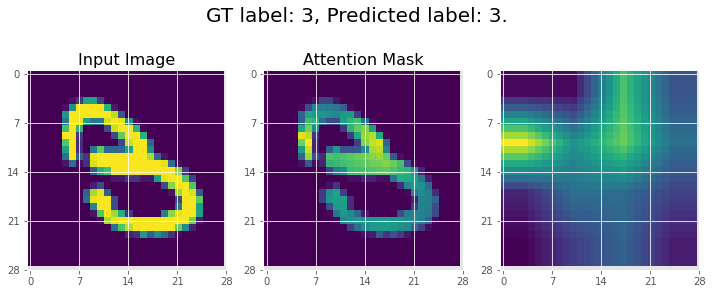

In [ ]:
img_id = 8
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = 255 * ( (preprocessed_img_orig * std) + mean )
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 255.0
tensor([0.0604, 0.0607, 0.0647, 0.0614, 0.0610, 0.0637, 0.0651, 0.0620, 0.0627,
        0.0624, 0.0636, 0.0620, 0.0603, 0.0638, 0.0652, 0.0611])
[[0.0251822  0.03117427 0.09340525 0.04130941]
 [0.03454661 0.07908314 0.10078144 0.05099626]
 [0.06277352 0.05810863 0.07624709 0.05149052]
 [0.02396204 0.07974713 0.10230012 0.03690444]]


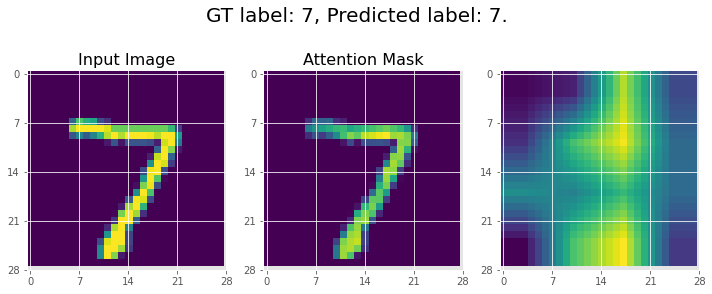

In [ ]:
img_id = 10
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = 255 * ( (preprocessed_img_orig * std) + mean )
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 255.0


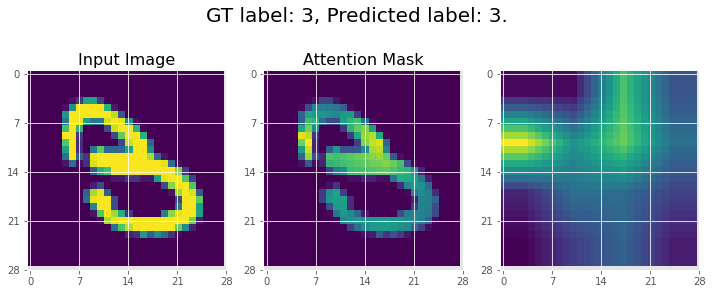

In [ ]:
img_id = 8
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = 255 * ( (preprocessed_img_orig * std) + mean )
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 255.0


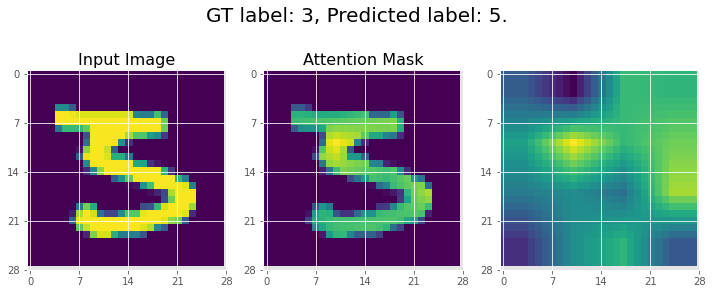

In [ ]:
img_id = 5
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = 255 * ( (preprocessed_img_orig * std) + mean )
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 255.0


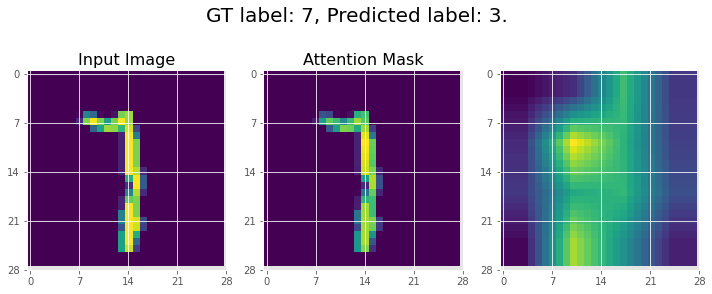

In [ ]:
img_id = 1
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = 255 * ( (preprocessed_img_orig * std) + mean )
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 255.0


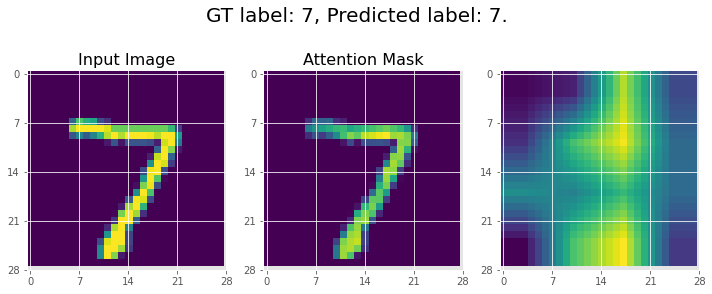

In [ ]:
img_id = 10
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = 255 * ( (preprocessed_img_orig * std) + mean )
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 255.0


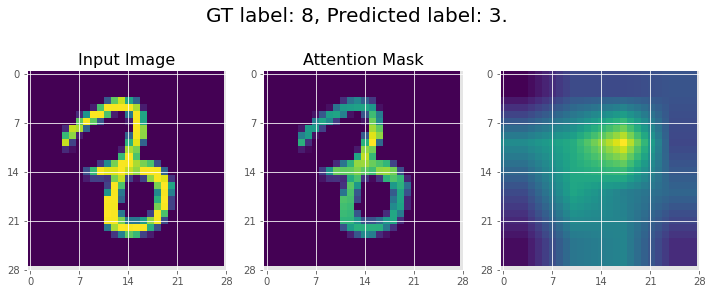

In [ ]:
img_id = 6
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

#De-normalization
preprocessed_img_orig = 255 * ( (preprocessed_img_orig * std) + mean )
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 254.0


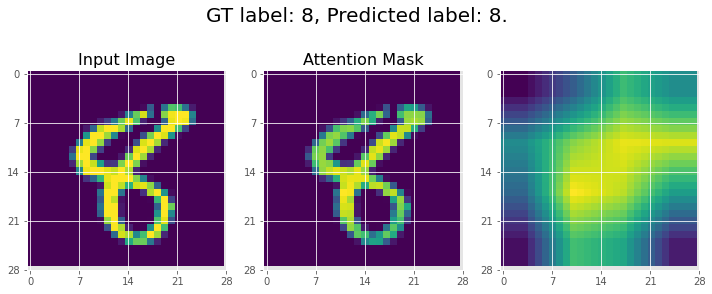

In [ ]:
img_id = -3
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

#De-normalization
preprocessed_img_orig = 255 * ( (preprocessed_img_orig * std) + mean )
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

## Attention Heatmaps

A Transformer block consists of multiple heads. Each head in a Transformer block projects the input data to different sub-spaces. This helps each individual head to attend to different parts of the image. Therefore, it makes sense to visualize each attention head map seperately, to make sense of what each heads looks at.

In [ ]:
def attention_heatmap(attention_score_dict, image, img_id, patch_size, num_heads):
    num_prefix_tokens = 1 #CLS token

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-1]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // patch_size #=number of patches per dimension
    h_featmap = image.shape[1] // patch_size
    attention_scores = attention_score_dict[attention_score_list[0]] #take the last key (last layer)
    #print(attention_score_list[0])

    # Taking the representations from CLS token.
    attentions = attention_scores[img_id, :, 0, num_prefix_tokens:].reshape(num_heads, -1)
    print(F.softmax(attentions, dim=-1))

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, h_featmap, w_featmap)

    # Resize the attention patches to the original image size
    attentions = torchvision.transforms.Resize(
         size=(h_featmap * patch_size, w_featmap * patch_size)
    )(attentions)

    return attentions.numpy() #(num_heads, h, w)

def visualize_attention_heatmaps(attention_score_dict, image, predicted_label, gt_label, img_id, patch_size, num_heads):
  # Generate the attention heatmaps.
  attentions = attention_heatmap(attention_score_dict, image, img_id, patch_size, num_heads)
  #print(attentions.shape)

  # Plot the maps.
  fig, axes = plt.subplots(nrows=int(num_heads/4), ncols=4, figsize=(10, 10))
  fig.suptitle(f"GT label: {gt_label}, Predicted label: {predicted_label}.", fontsize=20)
  n_ticks = np.sqrt(num_patches) + 1
  for h in range(num_heads):
    i = h//4
    j = h - (i*4)
    axes[i, j].imshow(image[0], cmap='gray')
    axes[i, j].imshow(attentions[h, :, :], cmap="inferno", alpha=0.7)
    axes[i, j].title.set_text(f"Attention head: {h}")
    #axes[i, j].axis("off")
    axes[i, j].set_xticks(np.arange(n_ticks)*patch_size)
    axes[i, j].set_yticks(np.arange(n_ticks)*patch_size)

  plt.tight_layout()
  fig.subplots_adjust(top=1.1)

tensor([[0.0650, 0.0630, 0.0640, 0.0643, 0.0632, 0.0600, 0.0600, 0.0650, 0.0641,
         0.0622, 0.0611, 0.0605, 0.0650, 0.0611, 0.0596, 0.0618],
        [0.0577, 0.0577, 0.0577, 0.0577, 0.0698, 0.0577, 0.0577, 0.0581, 0.0577,
         0.0577, 0.0652, 0.0577, 0.0577, 0.0577, 0.1140, 0.0577],
        [0.0601, 0.0585, 0.0608, 0.0607, 0.0830, 0.0587, 0.0839, 0.0595, 0.0599,
         0.0585, 0.0589, 0.0600, 0.0597, 0.0592, 0.0597, 0.0589],
        [0.0591, 0.0635, 0.0589, 0.0589, 0.0587, 0.0675, 0.0598, 0.0614, 0.0592,
         0.0770, 0.0693, 0.0590, 0.0591, 0.0644, 0.0631, 0.0611],
        [0.0565, 0.0565, 0.0565, 0.0565, 0.0565, 0.0566, 0.0565, 0.0565, 0.0565,
         0.0567, 0.0569, 0.0565, 0.0565, 0.0565, 0.1516, 0.0565],
        [0.0594, 0.0590, 0.0592, 0.0591, 0.0616, 0.0594, 0.0665, 0.0598, 0.0591,
         0.0609, 0.0659, 0.0680, 0.0603, 0.0595, 0.0768, 0.0655],
        [0.0564, 0.0565, 0.0564, 0.0564, 0.0564, 0.1534, 0.0564, 0.0564, 0.0564,
         0.0564, 0.0564, 0.0564, 0.05

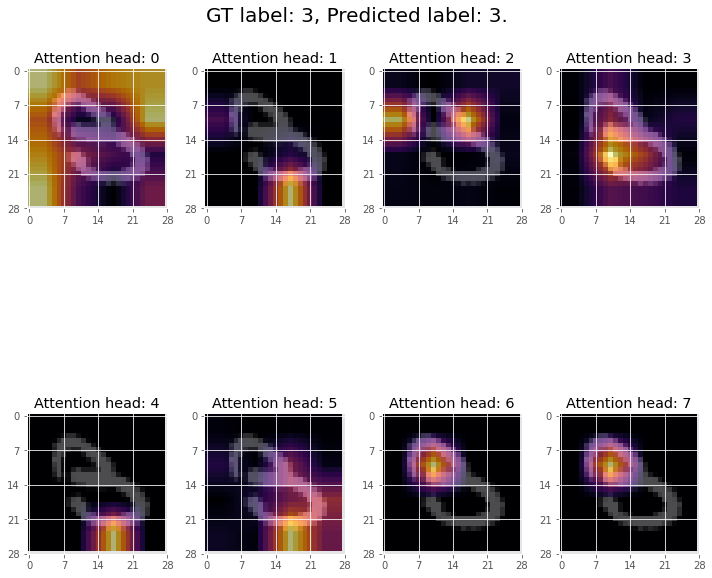

In [ ]:
img_id = 8
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

visualize_attention_heatmaps(attn_weights_dict, preprocessed_img_orig, predicted_label, gt_label, img_id, patch_size, num_heads)

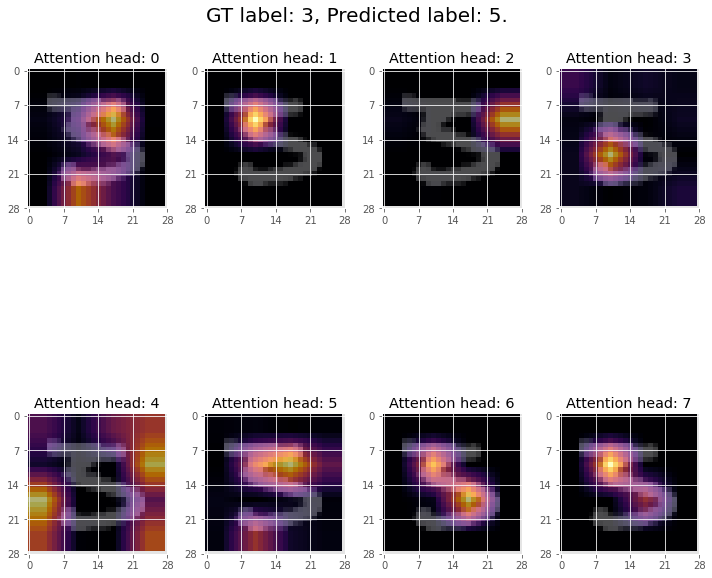

In [ ]:
img_id = 5
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

visualize_attention_heatmaps(attn_weights_dict, preprocessed_img_orig, predicted_label, gt_label, img_id, patch_size, num_heads)

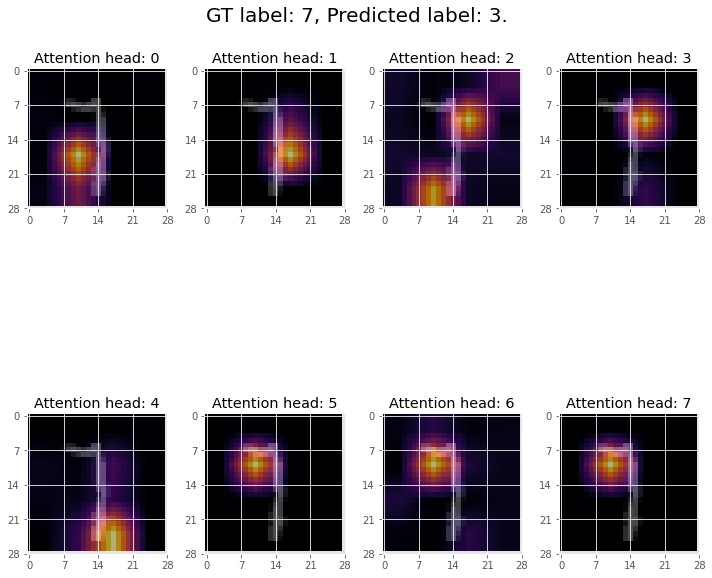

In [ ]:
img_id = 1
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

visualize_attention_heatmaps(attn_weights_dict, preprocessed_img_orig, predicted_label, gt_label, img_id, patch_size, num_heads)

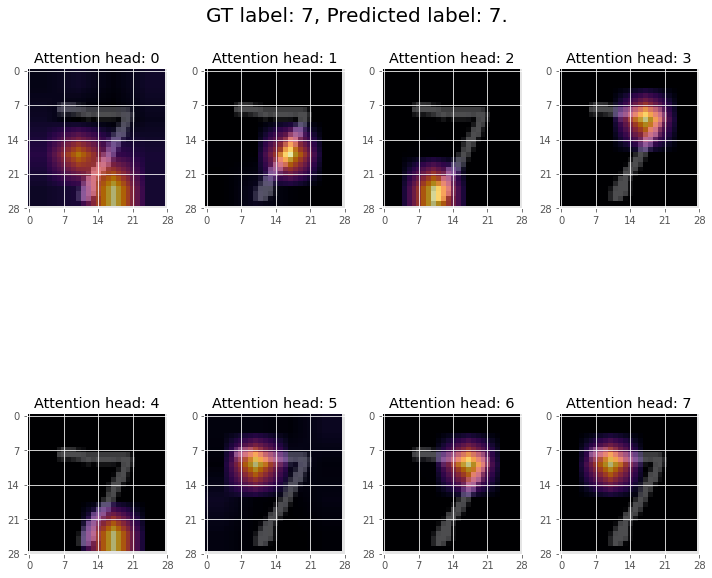

In [ ]:
img_id = 10
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

visualize_attention_heatmaps(attn_weights_dict, preprocessed_img_orig, predicted_label, gt_label, img_id, patch_size, num_heads)

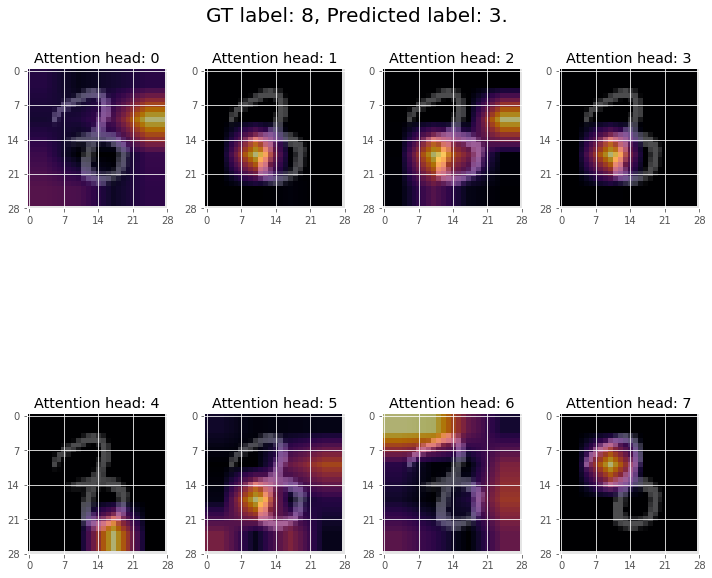

In [ ]:
img_id = 6
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

visualize_attention_heatmaps(attn_weights_dict, preprocessed_img_orig, predicted_label, gt_label, img_id, patch_size, num_heads)

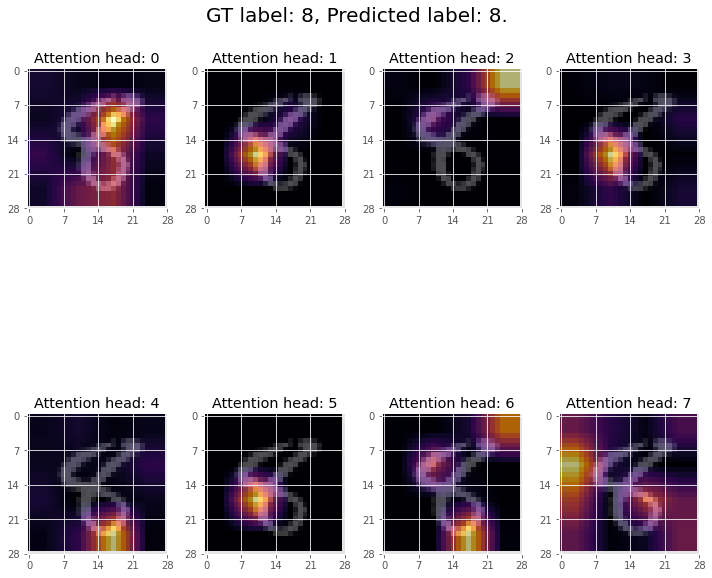

In [ ]:
img_id = -3
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

visualize_attention_heatmaps(attn_weights_dict, preprocessed_img_orig, predicted_label, gt_label, img_id, patch_size, num_heads)

## Patch Embeddings

In [ ]:
patch_embeddings = best_model_cp['model_state_dict']['embedding.patch_embeddings.weight']
#shape = [d_model, in_channels, patch_size, patch_size] = [64,1,7,7]--> 64 different kernels applied over 7x7 pixels/patch_dim
patch_embeddings = torch.reshape(patch_embeddings, (patch_size, patch_size, model.d_model)) #shape = (49, 64)
print(patch_embeddings.size())
#MAYBE RESHAPE to 7,7,64 and see the 2D kernels (search for a pattern)
patch_embeddings_np = patch_embeddings.cpu().data.numpy()

torch.Size([7, 7, 64])


In [ ]:
patch_embeddings_bias = best_model_cp['model_state_dict']['embedding.patch_embeddings.bias']
patch_embeddings_bias.size()

torch.Size([64])

In [ ]:
def TSNE_pembeddings(imgs):
  N = imgs.shape[0]
  x = torch.from_numpy(imgs).float().to(device)
  x_emb = model.embedding.patch_embeddings(x)
  #bs, num_kernels, h, w = x_emb.size()
  x_emb = x_emb.flatten(2).transpose(1, 2) #(bs, h*w, num_kernels)
  print(f"Range of values of the learned patch embeddings: [{x_emb.min()}, {x_emb.max()}]")
  X = x_emb.flatten(1)
  E = TSNE(n_components=3).fit_transform(X.detach().cpu())
  return E

def visualize_TSNE(E, Y, Y_pred, fig_name='TSNE_PE_test'):
  # set up a figure twice as wide as it is tall
  fig = plt.figure(figsize=(15,20))
  # =============
  # First subplot
  # =============
  # set up the axes for the first plot
  ax = fig.add_subplot(2, 1, 1, projection='3d')

  s = ax.scatter(E[:,0], E[:,1], E[:,2], c=Y, cmap='tab10')
  ax.grid(False)
  ax.set_title("GT labels")
  fig.colorbar(s, shrink=0.5, ticks=np.arange(10), boundaries=np.arange(11) - .5)

  ax_ = fig.add_subplot(2, 1, 2, projection='3d')

  s_pred= ax_.scatter(E[:,0], E[:,1], E[:,2], c=Y_pred, cmap='tab10')
  ax_.grid(False)
  ax_.set_title("Pred labels")
  fig.colorbar(s_pred, shrink=0.5, ticks=np.arange(10), boundaries=np.arange(11) - .5)
  plt.savefig('{}results/plots/{}/{}.png'.format(base_path, model_name, fig_name))

In [ ]:
all_imgs, all_gt, all_pred_labels, _, _ = test(model, test_loader_plots, n=None)

In [ ]:
print(all_imgs.shape, all_gt.shape, all_pred_labels.shape)
print(all_gt, all_pred_labels)

(10000, 1, 28, 28) (10000,) (10000,)
[7 2 1 ... 4 5 6] [7 2 1 ... 4 5 6]


Range of values of the learned patch embeddings: [-32.48417663574219, 27.040224075317383]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


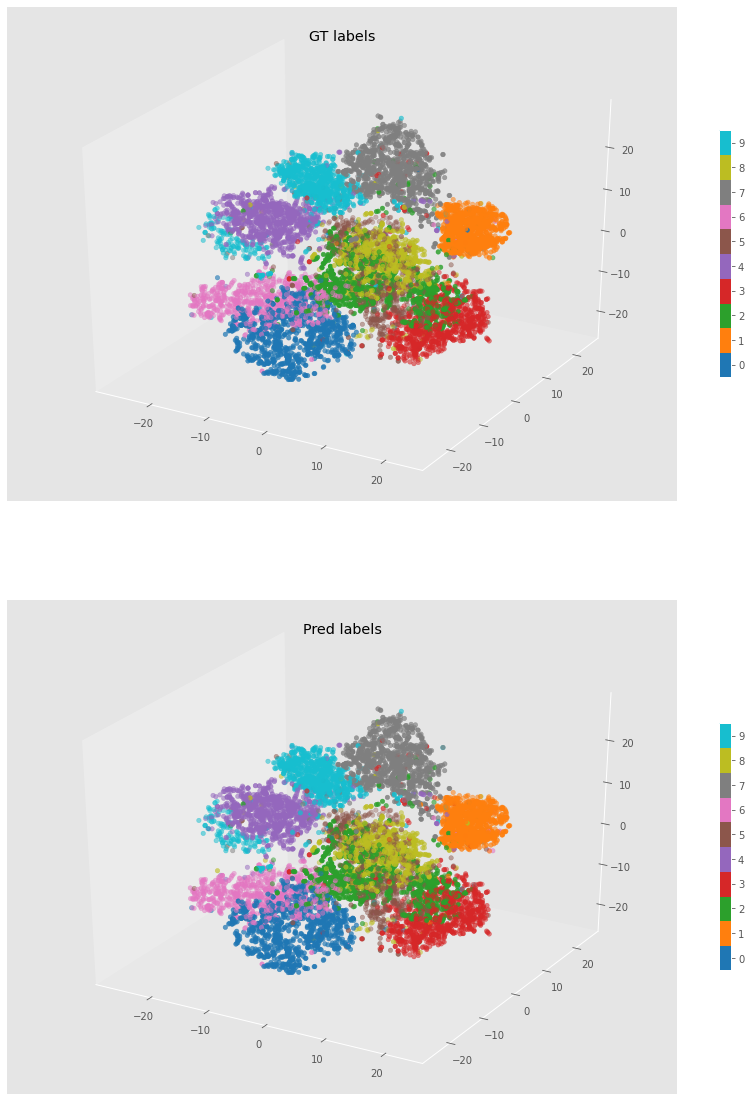

In [ ]:
E = TSNE_pembeddings(all_imgs)
visualize_TSNE(E, all_gt, all_pred_labels, fig_name='TSNE_PE_test')

In [ ]:
wrong_pred = np.where(all_gt!=all_pred_labels)[0]
incorrect = wrong_pred.shape[0] / all_pred_labels.shape[0] * 100
print("Rate of correct prediction: ", 100 - incorrect)

count_wp = {}
for id in wrong_pred:
  gt , pred = all_gt[id], all_pred_labels[id]
  if gt not in count_wp.keys():
    count_wp[gt] = [pred]
  else:
    count_wp[gt].append(pred)

Rate of correct prediction:  98.46


In [ ]:
#for each gt label,  shows the wrong predicted labels (Confusion between labels)
for gt in count_wp.keys():
  print(gt, ': ' ,count_wp[gt])

2 :  [3, 7, 6, 6, 3, 0, 4, 5, 7, 8, 1, 3, 8]
9 :  [8, 0, 0, 3, 8, 3, 4, 2, 0, 4, 4, 7, 5, 7, 5, 4, 3, 4, 4, 4, 7, 4, 4, 3, 4, 4]
4 :  [6, 9, 8, 6, 6, 6, 6, 7, 0, 8, 7, 9, 9]
5 :  [3, 3, 8, 7, 7, 3, 3, 3, 6, 3, 3, 3, 0, 9, 0, 0, 8, 2, 3, 3, 6, 3, 3, 3, 8, 6, 0, 0]
3 :  [5, 5, 7, 7, 8, 2, 5, 2, 8, 9]
6 :  [5, 5, 8, 4, 1, 0, 4, 4, 5, 4, 5, 3, 8]
8 :  [3, 2, 4, 9, 9, 7, 3, 1, 9, 9, 0, 2, 2, 6, 5]
7 :  [3, 8, 9, 2, 9, 3, 4, 3, 1, 2, 8, 3, 1, 3, 0, 2, 2, 2, 2]
1 :  [3, 3, 2, 2, 3, 6, 5, 8, 6, 6]
0 :  [6, 8, 8, 7, 8, 6, 8]


## Positional Embeddings

In [ ]:
pos_embeddings = best_model_cp['model_state_dict']['pos_embed.pe']
# shape = [1, num_patches + 1, d_model] = [1,17,64]
pos_embeddings = torch.reshape(pos_embeddings, (-1, model.d_model)) #shape = (17, 64)
print(pos_embeddings.size())
pos_embeddings_np = pos_embeddings.cpu().data.numpy()

torch.Size([17, 64])


In [ ]:
print(pos_embeddings_np.min(), pos_embeddings_np.max())

-3.9233255 4.5114155




> As we've seen in "Patch Embededings" subsection, the projected embeddings have values in the range of [-32.48, 27.04]. So, adding this positional embeddings is only making small perturbations to each embedded dimension.


> Nonetheless, they seem to make a difference in the model's performance (≃ 2% variation in val_acc - see "Vision Transformer Model")





The positional information can be in the form of leaned positional embeddings or handcrafted constant embeddings. In this case, ViTs feature learned positional embeddings (standard1Dpos model hyperparameter = False)

Below, we visualize the similarities between the learned positional embeddings with itself. The main diagonal is the brightest signifying that a position is the most similar to itself.

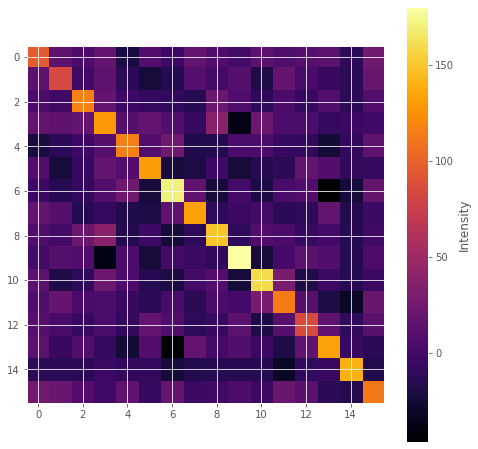

In [ ]:
# Discard the batch dimension and the position embeddings of the
# cls token.
position_embeddings = pos_embeddings_np[1:, ...]

similarity = position_embeddings @ position_embeddings.T
fig = plt.figure(figsize=(8,8))
im = plt.imshow(similarity, cmap="inferno")
im.cmap.set_under("w")
cbar = fig.colorbar(im, label='Intensity')
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def visualize_pe2D(pe):
  n_patches_perdim = int(math.sqrt(num_patches))
  #pe_2D = pe.reshape(n_patches_perdim, n_patches_perdim, -1) #size=(num_patches, d_model)

  cos_similarity = np.zeros((n_patches_perdim, n_patches_perdim, num_patches))

  for row in range(cos_similarity.shape[0]):
    for col in range(cos_similarity.shape[1]):
      #patch = pe_2D[np.newaxis,row, col, :]
      patch = pe[row*n_patches_perdim + col, :] #size=(1,64)
      sim = cosine_similarity(patch[np.newaxis, ...], pe) #size=(1,num_patches)
      cos_similarity[row, col, :] = sim

  fig, ax = plt.subplots(n_patches_perdim, n_patches_perdim, figsize=(8,8))
  for i in range(n_patches_perdim):
    for j in range(n_patches_perdim):
      patch_sim = cos_similarity[i,j,:].reshape(n_patches_perdim, n_patches_perdim)
      #plots the cos sim between the patch corresponding to position (i,j) in the image and all the other patches
      im = ax[i,j].imshow(patch_sim, vmin=-1.)
      if j==0:
        ax[i,j].set_ylabel(f"Row {i}")
      if i==n_patches_perdim-1:
        ax[i,j].set_xlabel(f"Col {j}")

  im.cmap.set_under("w")
  cbar = fig.colorbar(im, ax=ax.ravel().tolist(), label='Intensity')
  return cos_similarity

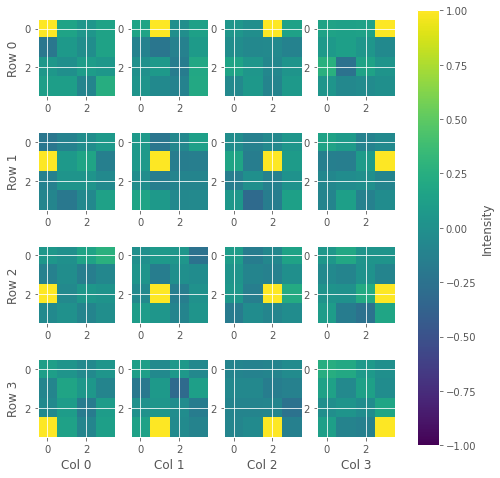

In [ ]:
position_embeddings = pos_embeddings_np[1:, ...]
c = visualize_pe2D(position_embeddings)

Here, we visualize the dimensions of each learned positional embedding (1 for each token/row):

In [ ]:
def plot_embeddings(emb, x_label, y_label, title, th=None, normalize=False):
  if normalize=='emb_dim':
    pm = emb.astype('float') / emb.sum(axis=0)[np.newaxis, :]
    print("Normalized each embedding dimension")
  elif normalize=='token':
    pm = emb.astype('float') / emb.sum(axis=1)[:, np.newaxis]
    print("Normalized each embedding dimension")
  elif th is not None:
    pm = np.zeros(emb.shape)
    pm[emb > th] = emb[emb > th]
    print(f"Values lower than {th} were set to 0")
  else:
    pm = emb

  plt.figure(figsize=(20,30))
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  im = plt.imshow(pm,  cmap="Blues")
  im.cmap.set_under("w")
  #ax = plt.gca()
  #divider = make_axes_locatable(ax)
  #cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im, shrink=0.2, label='Intensity')

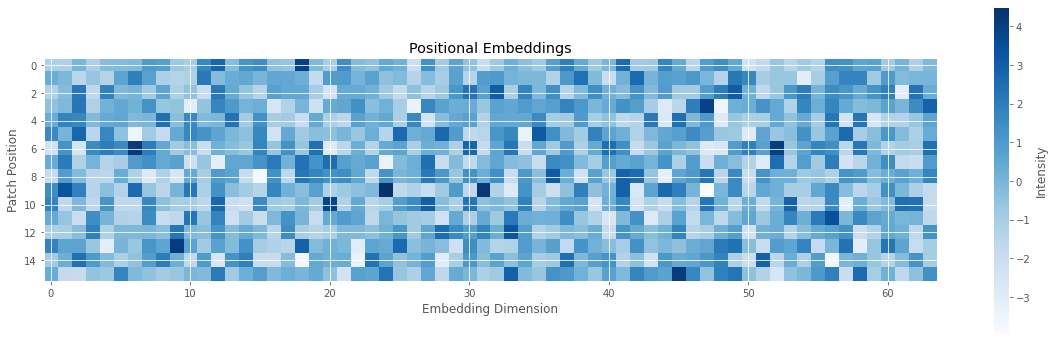

In [ ]:
title="Positional Embeddings"
xlabel="Embedding Dimension"
ylabel="Patch Position"
plot_embeddings(pos_embeddings_np[1:, ...], xlabel, ylabel, title, th=None, normalize=False)

Normalized each embedding dimension


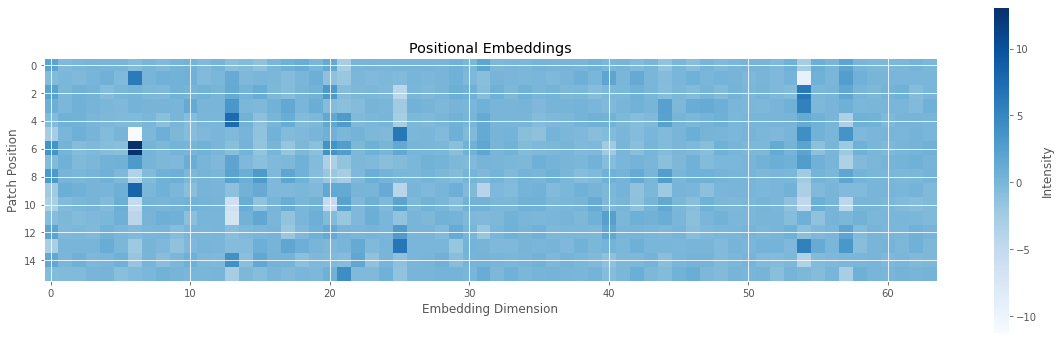

In [ ]:
plot_embeddings(pos_embeddings_np[1:, ...], xlabel, ylabel, title, th=None, normalize='emb_dim')

Normalized each embedding dimension


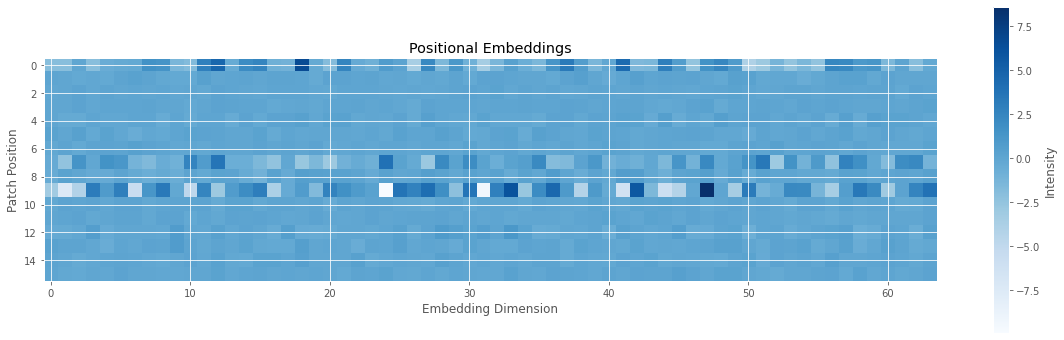

In [ ]:
plot_embeddings(pos_embeddings_np[1:, ...], xlabel, ylabel, title, th=None, normalize='token')

Values lower than 0 were set to 0


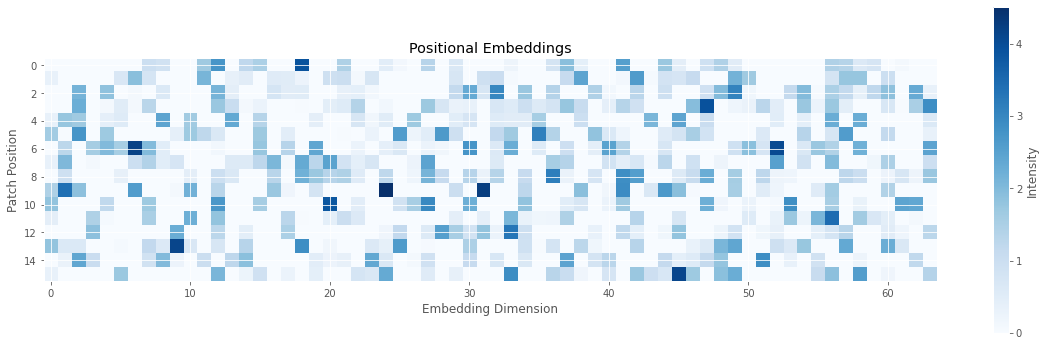

In [ ]:
plot_embeddings(pos_embeddings_np[1:, ...], xlabel, ylabel, title, th=0, normalize=None)